In [1]:

import warnings
warnings.filterwarnings('ignore')
import datetime
from torch.utils.data import Dataset
from skimage.transform import resize
import cv2
from zipfile import ZipFile
import os
import torch
from sklearn.utils import shuffle

import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from Datasets.Dataset import Dataset,Scale,ToTensor,visualize_loader,Normalize,ToLmdb
from Models.Facenet import Resnet34Triplet
from Models.M2FPA import load_model,save_model,set_requires_grad\
,init_weights,Discriminator,ParserDiscriminator,Generator
# from Models.AlternateGenerator import Generator
from Models.Bisnet import BiSeNet,vis_parsing_maps,re_normalize_batch,ParserMaps
from Losses import TVLoss,DetectionLoss
import skimage
from skimage.io import imread,imsave
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm 
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
import shutil
import random
import pandas as pd
import torchvision.transforms as transforms


In [6]:
import lmdb
from io import BytesIO

In [8]:
total=0

def resize_and_convert(img, quality=100):

    buffer = BytesIO()
    np.save(buffer,img)
    val = buffer.getvalue()

    return val
with lmdb.open('test.lmdb', map_size=1024 ** 4, readahead=False) as env:
    with env.begin(write=True) as txn:
        for i,img in tqdm(enumerate(x)):
            key = '{}'.format(str(i).zfill(3)).encode('utf-8')
            txn.put(key, resize_and_convert(img.numpy()))

            total += 1
            
        txn.put('length'.encode('utf-8'), str(total).encode('utf-8'))
        txn.put('normalize'.encode('utf-8'), str(total).encode('utf-8'))

16
(2, 512, 512, 3)


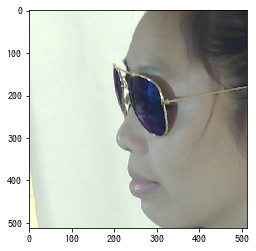

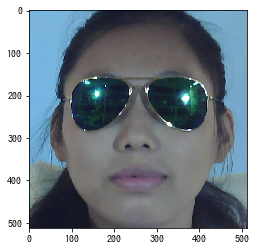

In [14]:
env = lmdb.open(
            'Utils/train.lmdb',
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
with env.begin(write=False) as txn:
    length = int(txn.get('length'.encode('utf-8')).decode('utf-8'))
print(length)
with env.begin(write=False) as txn:
    key = '{}'.format(str(3).zfill(3)).encode('utf-8')
    img_bytes = txn.get(key)
    
buffer = BytesIO(img_bytes)
img_re=np.load(buffer)
print(img_re.shape)
plt.imshow(img_re[0]);plt.show()
plt.imshow(img_re[1]);plt.show()

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
BATCH_SIZE=16
START_EPOCHS=0
END_EPOCHS=10
CRITIC_ITER=10


LAMBDA_PIXEL=20
LAMBDA_DETECT=0.08
LAMBDA_ADV_PARSER=1
LAMBDA_TV=1e-4
LAMBDA_ADV=1



In [3]:
transform=ToLmdb()#torchvision.transforms.Compose([Scale(),ToTensor(),Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset=Dataset('M2FPA_TRAIN.csv',transform)
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
NO_STEPS=train_dataset.__len__()//BATCH_SIZE
print("NUMBER OF BATCHES : ",train_loader.__len__())
x=next(iter(train_loader))

NUMBER OF BATCHES :  16160


In [4]:
for y in x:
    print(y.shape)

torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])
torch.Size([2, 512, 512, 3])


In [ ]:
input_image,gt_image=visualize_loader(train_loader,index=1)
print("MAX VALUE : ","\ninput_image",np.max(input_image),"\ngt_image",np.max(gt_image))
print("MIN VALUE : ","\ninput_image",np.min(input_image),"\ngt_image",np.min(gt_image))
print("IMG SIZE : ","\ninput_image",input_image.shape,"\ngt_image",gt_image.shape)
plt.imshow(input_image);plt.show()
plt.imshow(gt_image);plt.show()

In [ ]:

model_parser=BiSeNet(19)
load_model('Weights/Parser.pth',model_parser)
model_detect=Resnet34Triplet()
load_model('Weights/Facenet.pth',model_detect)
modelG=Generator()#(norm='batch',activation='lrelu')
init_weights(modelG)
modelD=Discriminator(norm='batch',activation='lrelu')
init_weights(modelD)
modelD_parser=ParserDiscriminator(norm='batch',activation='lrelu')
init_weights(modelD_parser)

model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('model_{} dir has been made'.format(model_start_date))
print("Model's state_dict:")
print()
print(color.BOLD + 'GENERATOR' + color.END)
for param_tensor in modelG.state_dict():
    print(param_tensor, "\t", modelG.state_dict()[param_tensor].size())

print(color.BOLD + 'DISCRIMINATOR' + color.END)
for param_tensor in modelD.state_dict():
    print(param_tensor, "\t", modelD.state_dict()[param_tensor].size())
    
    
print(color.BOLD + 'DISCRIMINATOR PARSER' + color.END)
for param_tensor in modelD_parser.state_dict():
    print(param_tensor, "\t", modelD_parser.state_dict()[param_tensor].size())



In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modelG = modelG.to(device)
modelD = modelD.to(device)
modelD_parser=modelD_parser.to(device)

parser_map_generator=ParserMaps(model_parser)


model_parser.eval()
model_detect.eval()
modelG.train()
modelD.train()
modelD_parser.train()



criterion_feature=DetectionLoss(model_detect).to('cuda')
criterion_mse=torch.nn.MSELoss().to('cuda')
criterion_tv=TVLoss().to('cuda')



optimizerG = torch.optim.Adam(modelG.parameters(),lr=10e-03, betas=(0.9, 0.98),weight_decay=0.02)
optimizerD = torch.optim.SGD(modelD.parameters(),lr=10e-03, momentum=0.8,nesterov=True)
optimizerD_parser = torch.optim.SGD(modelD_parser.parameters(),lr=10e-03, momentum=0.8,nesterov=True)


best_val=10e06

for epoch in range(START_EPOCHS,END_EPOCHS):
    
    print("Learning Rate Generator : {}\nLearning Rate Discriminator : {}\nLearning Rate Discriminator 2 : {}"\
          .format(optimizerG.state_dict()['param_groups'][-1]['lr'],\
                  optimizerD.state_dict()['param_groups'][-1]['lr'],\
                 optimizerD_parser.state_dict()['param_groups'][-1]['lr']))
    gen_detect_score=0
    gen_pixel_loss=0
    
  # loop over the dataset multiple times

    loop=tqdm(train_loader)
    
    gen_train_steps=0

    for i, sample_batched in (enumerate(loop)):
        
        loop.set_description('Epoch {}/{}'.format(epoch + 1, END_EPOCHS))

        # get the inputs;
        input_image_batch, gt_image_batch= sample_batched['input_image'],\
        sample_batched['gt_image']

        input_image_batch, gt_image_batch = input_image_batch.to(device, dtype = torch.float)\
        ,gt_image_batch.to(device, dtype = torch.float)
        

        if (i+1)%CRITIC_ITER==0:
        ## Generator training ##
            
            set_requires_grad(modelD, requires_grad=False)
            set_requires_grad(modelD_parser, requires_grad=False)
            modelG.zero_grad()
            
            
            recon_front=modelG(input_image_batch)
            Discriminator_op=modelD(recon_front)
            x,y,z=parser_map_generator(recon_front)
            Discriminator_parser_op=modelD_parser(x,y,z)

            loss_G_detect=criterion_feature(recon_front,gt_image_batch)
            loss_G_pixel=criterion_mse(recon_front,gt_image_batch)
            loss_G_D=1-Discriminator_op.mean()
            loss_G_D_parser=1-Discriminator_parser_op.mean()
            loss_G_tv=criterion_tv(recon_front)
            
            loss_G=LAMBDA_PIXEL*loss_G_detect+LAMBDA_DETECT*loss_G_detect+\
            LAMBDA_ADV_PARSER*loss_G_D_parser+LAMBDA_TV*loss_G_tv+LAMBDA_ADV*loss_G_D
            
            loss_G.backward()
            optimizerG.step()
            
            gen_detect_score=gen_detect_score*0.9+loss_G_detect.detach().item()*0.1
            gen_pixel_loss=gen_pixel_loss*0.9+loss_G_pixel.detach().item()*0.1
            
            loop.set_postfix(Pixel_loss=gen_pixel_loss,Detection_loss=gen_detect_score)

            
            if (i+1)%500==0:

                img_train = torchvision.utils.make_grid(recon_front.detach().cpu()\
                                                        ,nrow=BATCH_SIZE//4,padding=40)
            
                torchvision.utils.save_image(img_train,os.path.join(os.getcwd(),\
                                                                    BEST_MODEL_PATH+'/train_iter_{}.png'.\
                                                                    format(epoch*len(train_loader)+i+1)))
                save_model(modelD,optimizerD,os.path.join(BEST_MODEL_PATH\
                                                          ,'Discriminator_{}.pth'.format\
                                                          (epoch*len(train_loader)+i+1)),scheduler=None)
                save_model(modelD_parser,optimizerD_parser,os.path.join(BEST_MODEL_PATH\
                                                          ,'Discriminator_parser_{}.pth'.format\
                                                          (epoch*len(train_loader)+i+1)),scheduler=None)
                
                save_model(modelG,optimizerG,os.path.join(BEST_MODEL_PATH,\
                                                          'Generator_{}.pth'.format\
                                                          (epoch*len(train_loader)+i+1)),scheduler=None)
        
            
        else:

            #Train discriminator
            

            set_requires_grad(modelD, requires_grad=True)
            modelD.zero_grad()
            
            set_requires_grad(modelD_parser, requires_grad=True)
            modelD_parser.zero_grad()
            
            recon_front_D=modelG(input_image_batch)
            
            Discriminator_op_recon=modelD(recon_front_D)
            Discriminator_op_gt=modelD(gt_image_batch)
            x_recon,y_recon,z_recon=parser_map_generator(recon_front_D)
            Discriminator_parser_op_recon=modelD_parser(x_recon,y_recon,z_recon)
            x_gt,y_gt,z_gt=parser_map_generator(gt_image_batch)
            Discriminator_parser_op_gt=modelD_parser(x_gt,y_gt,z_gt)
            
           
            loss_D=1-Discriminator_op_recon.mean()+Discriminator_op_gt.mean()
            loss_D_parser=1-Discriminator_parser_op_recon.mean()+Discriminator_parser_op_gt.mean()
            
            loss_D.backward(retain_graph=True)
            optimizerD.step()
            
            loss_D_parser.backward(retain_graph=True)
            optimizerD_parser.step()


save_model(modelG,optimizerG,os.path.join(MODEL_PATH,'Generator_final.pth'),scheduler=None)
print('Finished Training')


